In the [previous notebook](../apply_winsorization.ipynb), methods for removing outliers in the emissions spectra are studied. In this notebook, I examine the effects of applying these smoothing techniques on the fits themselves. I'll use Zac's `hyperFeatureSearch()` to determine which parameters provide the best fit.

In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pysyncon import Dataprep, Synth, AugSynth
import itertools

In [62]:
# All states:
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
# States belonging to RGGI. Exclude VA here; it was only in RGGI for a short time
# Connecticut, Delaware, Maine, Maryland, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, and Vermont 
rggi_states = ["CT", "DE", "ME", "MD", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
# States with cap-and-trade programs as well as AK and HI, which are of course outside the continental US.
# Ignore AK and HI because they aren't in the continental US
# Ignore CA and WA because they have strong CO2 policies in the pre-treatment period
# Ignore VA because it was only a member of RGGI briefly
# Ignore WY, ND, and WV because they are per capita emissions outliers
other_states = ["CA", "WA", "VA", "AK", "HI", "WY", "ND", "WV"]
# States not belonging to RGGI or other cap-and-trade programs.
# WA will be included here because its cap-and-trade program was not around until after 2020.
control_states = list(set(states) - set(rggi_states) - set(other_states))

# Verify all fifty states accounted for:
assert(len(rggi_states) + len(control_states) + len(other_states) == 50)

In [63]:
# Read in the dataframe
df = pd.read_csv(os.path.join("..", "..", "..", "SharedData", "total_state_data.csv"))
df.date = pd.to_datetime(df.date)
df = df[(df.date.dt.year>=1990)&(df.date.dt.year<2020)]

In [64]:
# Do some per capita calculations:
df['co2_per_capita']   = df['monthly_emissions']   / df['monthly_population']
df['gdp_per_capita']   = df['gdp_rel_2017_interp'] / df['monthly_population']
df['euse_per_capita']  = df['monthly_energy_use']  / df['monthly_population']
df['eprod_per_capita'] = df['monthly_energy_prod'] / df['monthly_population']
df['eflow_per_capita'] = df['monthly_energy_flow'] / df['monthly_population']

In [65]:
# Add some smoothing:
# Let's be a little agressive here for a more pronounced potential affect
# Remove the 5% extremes
from scipy.stats.mstats import winsorize
df["co2_per_capita_sma"] = df["monthly_emissions_sma"] / df["monthly_population"]
df["co2_per_capita_residuals"] = df["co2_per_capita"] - df["co2_per_capita_sma"]
winsorize(df["co2_per_capita_residuals"], limits=(0.05,0.05))
df["co2_per_capita_winsorized"] = df["co2_per_capita_residuals"] + df["co2_per_capita_sma"]

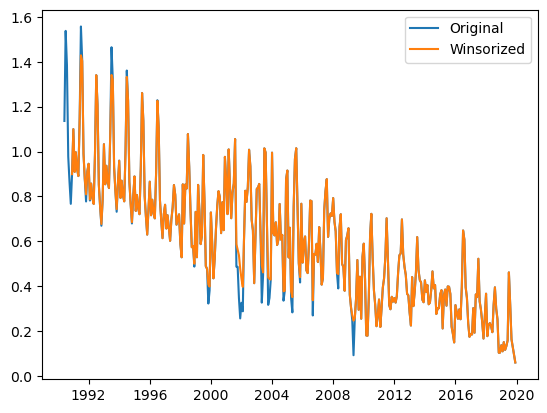

In [66]:
# Plot to make sure smoothing worked
plt.plot(df[df.state=="DE"].date, df[df.state=="DE"].co2_per_capita, label="Original")
plt.plot(df[df.state=="DE"].date, df[df.state=="DE"].co2_per_capita_winsorized, label="Winsorized")
plt.legend()
plt.show()

In [67]:
#monthly_features_of_interest_unscaled = ['monthly_emissions', 'prcp', 'snow', 'tavg', 
#        'gdp_rel_2017_interp', 'monthly_energy_prod',
#       'monthly_energy_use', 
#       'monthly_energy_flow', 
#        'monthly_renew_pct', 'monthly_fossil_pct',
#       'monthly_pop_density', 'monthly_emissions_sma']

monthly_features_of_interest = ['prcp', 'snow', 'tavg', 
        'gdp_per_capita', 
        'euse_per_capita', 'eprod_per_capita', 'eflow_per_capita', 
        'monthly_renew_pct', 'monthly_fossil_pct', 
        'monthly_pop_density']

def hyperFeatureSearch(numFeatures, filename, winsorize=False):
    scores_df = pd.DataFrame(columns=["Features", "AvgLossSyn"])
    scores_df = scores_df.astype('object')

    # Choose features to test
    for features in itertools.combinations(monthly_features_of_interest, numFeatures):
    
        # Loop over RGGI states
        loss_array = np.zeros(len(rggi_states))
        counter = 0
        for rggi_state in rggi_states:
            state_id = rggi_state 
            control_ids = list(set(control_states) - set([state_id]))
            rggi_ids = list(set(rggi_states) - set([state_id]))

            # Stop the notebook if something goes wrong
            assert(state_id not in other_states)
            assert(len(control_ids) + len(rggi_ids) + 1 == 50 - len(other_states))

            # Do computations monthly
            month_jumps = 1

            # Set up ranges
            UL = 2009
            LL_TIME = 1991 # 1997      # Time range over which to perform fit

            preintervention_time_range = df.date[(df.date.dt.year>=LL_TIME)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]

            #years = pd.date_range(start='1997-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]
            
            #special_predictors = [(feature, preintervention_time_range, 'mean') for feature in features]
            
            dependent = "co2_per_capita"
            if winsorize:
                dependent = "co2_per_capita_winsorized"
            additional_predictors = [feature for feature in features]

            dataprep_control = Dataprep(
                foo=df,
                predictors=[dependent]+additional_predictors,
                predictors_op="mean",
                time_predictors_prior=preintervention_time_range,
                #special_predictors=special_predictors,
                dependent=dependent,
                unit_variable="state",
                time_variable="date",
                treatment_identifier=state_id,
                controls_identifier= control_ids,
                time_optimize_ssr=preintervention_time_range
            )
            
            # Do a synthetic control fit to the data using control states
            synth = Synth()

            synth.fit(dataprep=dataprep_control)
            loss_array[counter] = synth.loss_V
            counter += 1
            
        feature_avg_loss = np.average(loss_array)
        result = pd.DataFrame(data=[[list(features),feature_avg_loss]], columns=["Features", "AvgLossSyn"], dtype='object')
        scores_df = pd.concat([scores_df, result])
        
    output = filename + "_" + str(numFeatures) + ".csv"
    scores_df.to_csv(output)

In [68]:
#hyperFeatureSearch(1, "hyperSearch_scores")
#print("One done")
#hyperFeatureSearch(2, "hyperSearch_scores")
#print("Two done")
hyperFeatureSearch(3, "hyperSearch_scores")
print("Three done")
#hyperFeatureSearch(4, "hyperSearch_scores")
#print("Four done")
#hyperFeatureSearch(5, "hyperSearch_scores")
#print("Five done")

Three done


In [69]:
#hyperFeatureSearch(1, "hyperSearch_scores_win", True)
#print("One done")
#hyperFeatureSearch(2, "hyperSearch_scores_win", True)
#print("Two done")
hyperFeatureSearch(3, "hyperSearch_scores_win", True)
print("Three done")
#hyperFeatureSearch(4, "hyperSearch_scores_win", True)
#print("Four done")
#hyperFeatureSearch(5, "hyperSearch_scores")
#print("Five done")

Three done


In [71]:
# Compare the results
for check_n in range(1,5):
    df_init = pd.read_csv(f"hyperSearch_scores_{check_n}.csv", index_col=0)
    df_win = pd.read_csv(f"hyperSearch_scores_win_{check_n}.csv", index_col=0)
    print(f"Parameters: {check_n}")
    print(df_init.sort_values(by="AvgLossSyn", ascending=True).head(5))
    print(df_win.sort_values(by="AvgLossSyn", ascending=True).head(5))

Parameters: 1
                 Features  AvgLossSyn
0    ['eprod_per_capita']    0.006926
0  ['monthly_fossil_pct']    0.007587
0   ['monthly_renew_pct']    0.008927
0     ['euse_per_capita']    0.009844
0    ['eflow_per_capita']    0.010551
                 Features  AvgLossSyn
0    ['eprod_per_capita']    0.006408
0  ['monthly_fossil_pct']    0.007064
0    ['eflow_per_capita']    0.008275
0   ['monthly_renew_pct']    0.009142
0     ['euse_per_capita']    0.009188
Parameters: 2
                                        Features  AvgLossSyn
0     ['eflow_per_capita', 'monthly_fossil_pct']    0.006917
0                 ['tavg', 'monthly_fossil_pct']    0.007270
0  ['monthly_fossil_pct', 'monthly_pop_density']    0.007975
0                   ['prcp', 'eprod_per_capita']    0.008008
0      ['eprod_per_capita', 'monthly_renew_pct']    0.008626
                                     Features  AvgLossSyn
0  ['eflow_per_capita', 'monthly_fossil_pct']    0.006443
0              ['tavg', 'monthly_f

/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


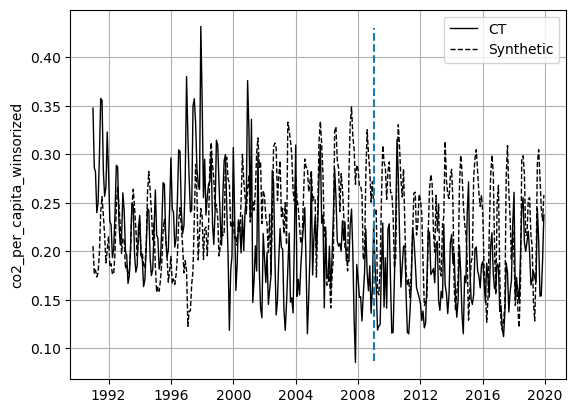

CT Weights: OR    0.463
ID    0.313
NM    0.012
FL    0.212
Name: weights, dtype: float64
CT Loss: 0.005845239052173499



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


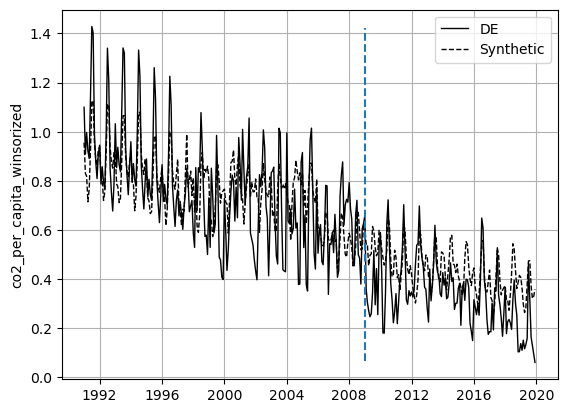

DE Weights: IA    0.046
ID    0.106
MN    0.322
NV    0.526
Name: weights, dtype: float64
DE Loss: 0.02584295298943117



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


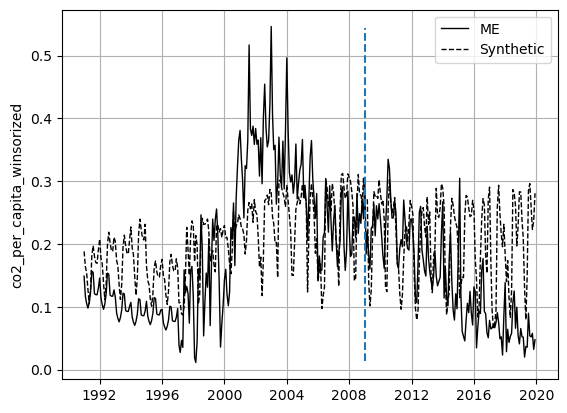

ME Weights: OR    0.622
ID    0.247
MN    0.111
NM    0.020
Name: weights, dtype: float64
ME Loss: 0.008096540365484961



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


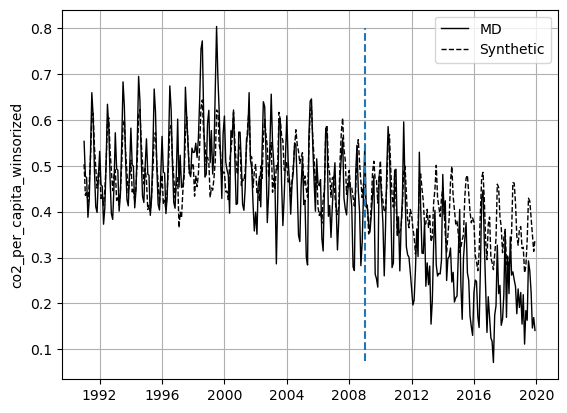

MD Weights: OR    0.323
ID    0.020
MI    0.116
SD    0.034
MN    0.041
CO    0.016
FL    0.350
WI    0.029
NV    0.071
Name: weights, dtype: float64
MD Loss: 0.004929077108477715



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


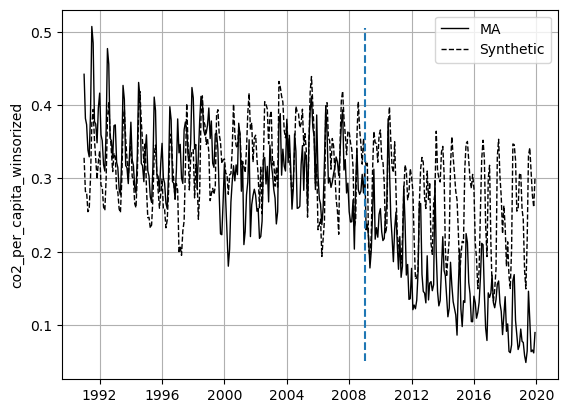

MA Weights: OR    0.560
ID    0.116
MN    0.067
FL    0.174
WI    0.008
NV    0.075
Name: weights, dtype: float64
MA Loss: 0.003676992449843473



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


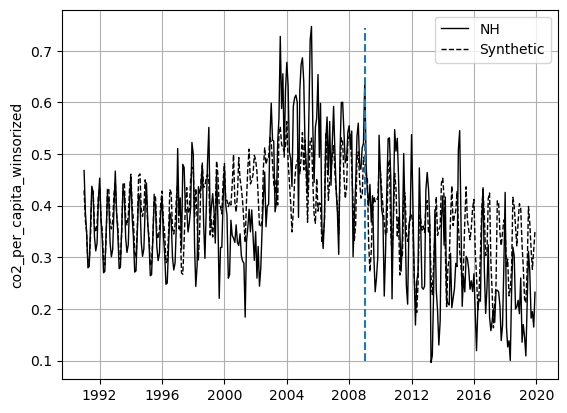

NH Weights: OR    0.453
MN    0.547
Name: weights, dtype: float64
NH Loss: 0.007074514307519635



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


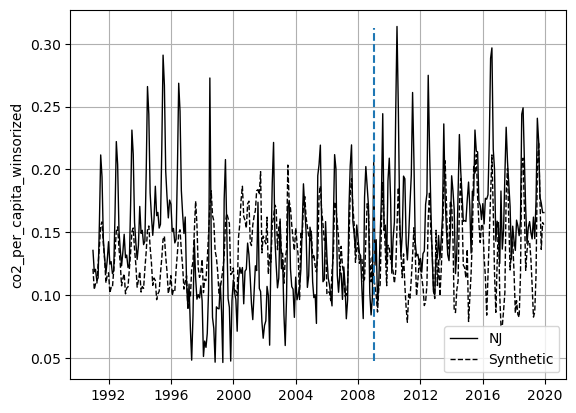

NJ Weights: OR    0.033
ID    0.802
FL    0.140
NV    0.026
Name: weights, dtype: float64
NJ Loss: 0.0020635629426847737



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


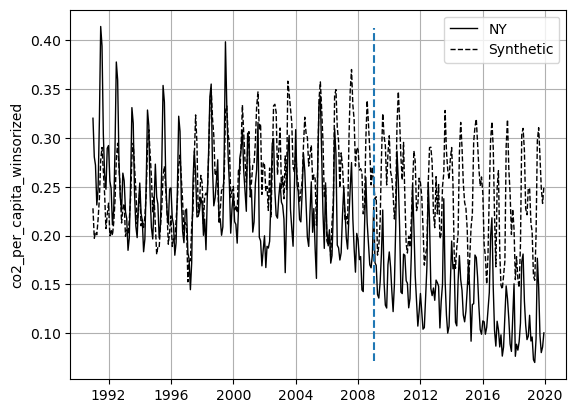

NY Weights: OR    0.352
ID    0.362
NM    0.013
FL    0.273
Name: weights, dtype: float64
NY Loss: 0.0029772620389548077



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


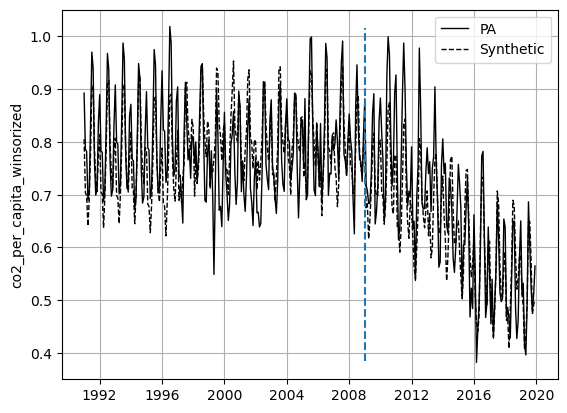

PA Weights: IA    0.008
UT    0.054
NE    0.015
KY    0.017
MT    0.033
AR    0.014
OK    0.008
NC    0.041
IN    0.008
MO    0.039
KS    0.009
GA    0.030
AL    0.011
TN    0.021
OR    0.102
AZ    0.074
ID    0.082
MI    0.031
SD    0.056
IL    0.044
MN    0.020
NM    0.044
SC    0.026
CO    0.044
FL    0.065
WI    0.026
OH    0.023
NV    0.054
Name: weights, dtype: float64
PA Loss: 0.004291903182986053



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


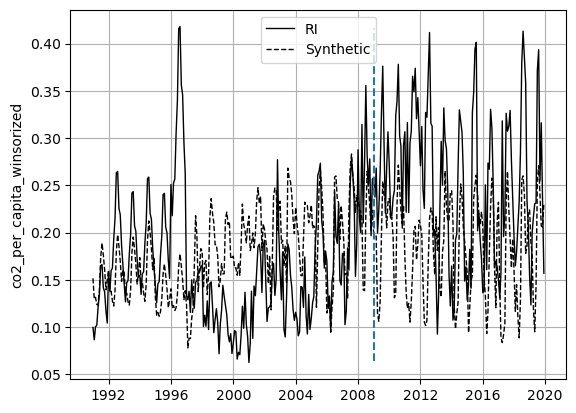

RI Weights: OR    0.432
ID    0.410
FL    0.158
Name: weights, dtype: float64
RI Loss: 0.0054216869416607895



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


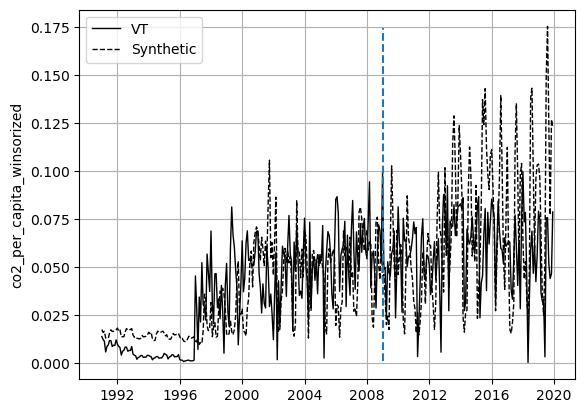

VT Weights: MT    0.008
ID    0.992
Name: weights, dtype: float64
VT Loss: 0.0004712163692481644



In [74]:
# Now just do a quick fit/plot of the best result
for state_id in rggi_states:
    #example_predictors = ['co2_per_capita_winsorized', 'prcp', 'tavg', 'eprod_per_capita', 'monthly_fossil_pct']
    example_predictors = ['co2_per_capita_winsorized', 'tavg', 'eprod_per_capita', 'eflow_per_capita', 'monthly_fossil_pct']
    example_time_range = df.date[(df.date.dt.year>=1991)&(df.date.dt.year<2009)&(df.state==state_id)]
    control_ids = list(set(control_states) - set([state_id]))
    dataprep_example = Dataprep(
                foo=df,
                predictors=example_predictors,
                predictors_op="mean",
                time_predictors_prior=example_time_range,
                #special_predictors=special_predictors,
                dependent="co2_per_capita_winsorized",
                unit_variable="state",
                time_variable="date",
                treatment_identifier=state_id,
                controls_identifier= control_ids,
                time_optimize_ssr=example_time_range
            )
    years = pd.date_range(start='1991-01-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()
    synth = Synth()
    synth.fit(dataprep=dataprep_example)
    synth.path_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
    plt.show()
    print(f"{state_id} Weights:", synth.weights(threshold=.001))
    print(f"{state_id} Loss:", synth.loss_V)
    print("")

/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


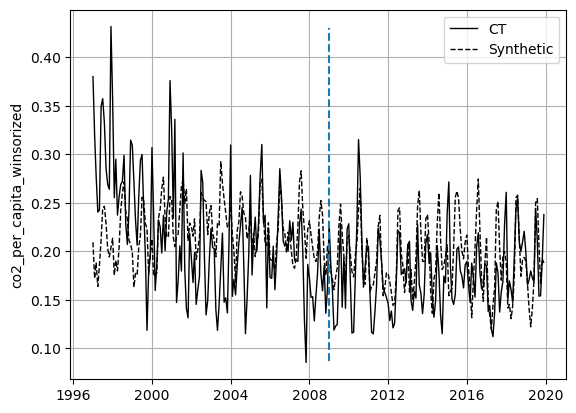

CT Weights: ID    0.689
MN    0.144
FL    0.166
Name: weights, dtype: float64
CT Loss: 0.004108902177545898



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


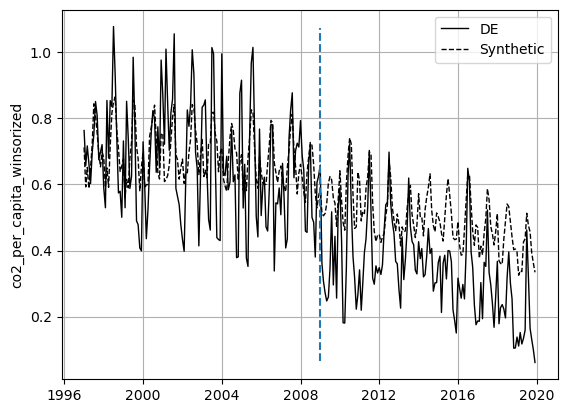

DE Weights: TN    0.137
MN    0.335
FL    0.500
MS    0.029
Name: weights, dtype: float64
DE Loss: 0.020542994780627485



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


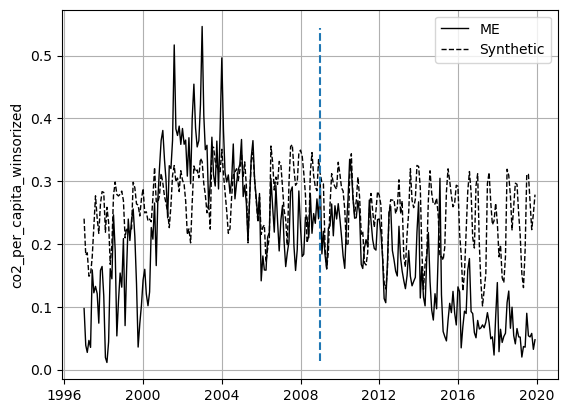

ME Weights: OR    0.430
ID    0.308
MN    0.226
NM    0.013
LA    0.023
Name: weights, dtype: float64
ME Loss: 0.009121087237783144



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


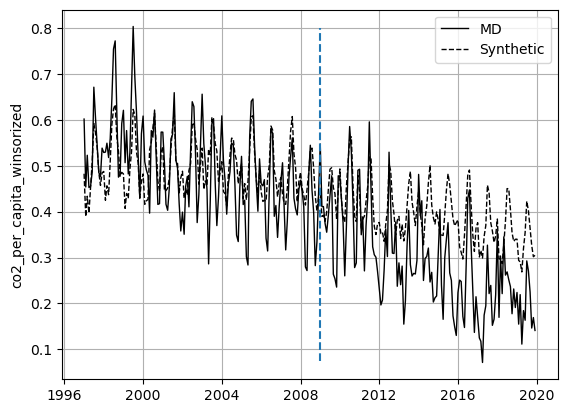

MD Weights: OR    0.073
ID    0.193
MI    0.103
SD    0.012
MN    0.196
LA    0.012
FL    0.410
Name: weights, dtype: float64
MD Loss: 0.005919804073809979



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


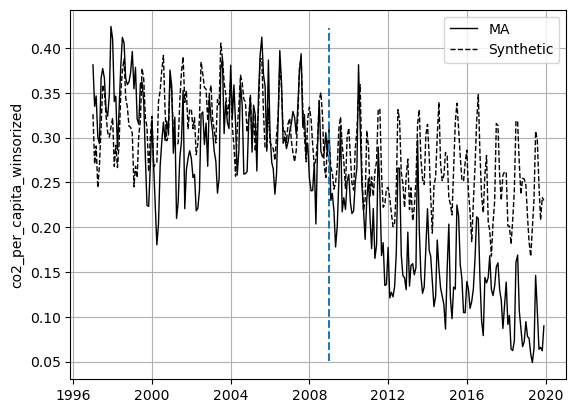

MA Weights: ID    0.530
MN    0.277
FL    0.193
Name: weights, dtype: float64
MA Loss: 0.002508076201461191



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


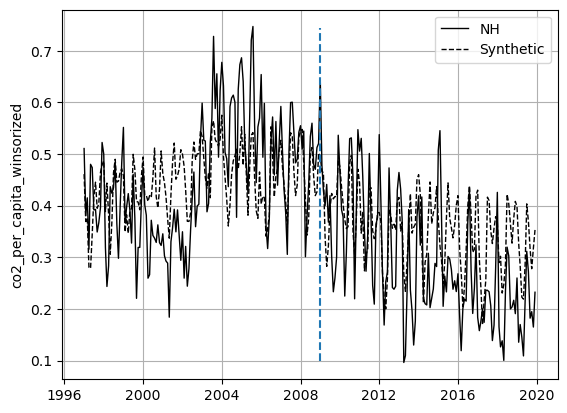

NH Weights: OR    0.43
MN    0.57
Name: weights, dtype: float64
NH Loss: 0.00989739350680013



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


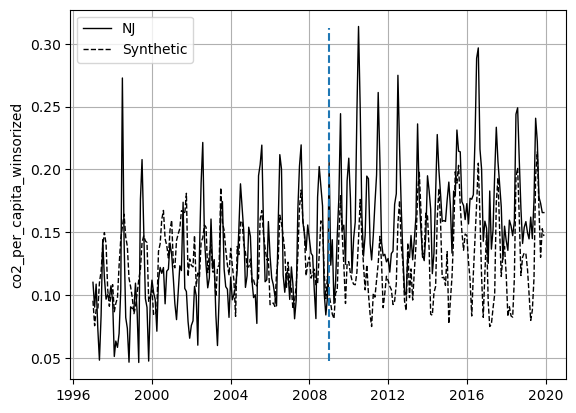

NJ Weights: ID    0.842
FL    0.158
Name: weights, dtype: float64
NJ Loss: 0.0012342904513101386



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


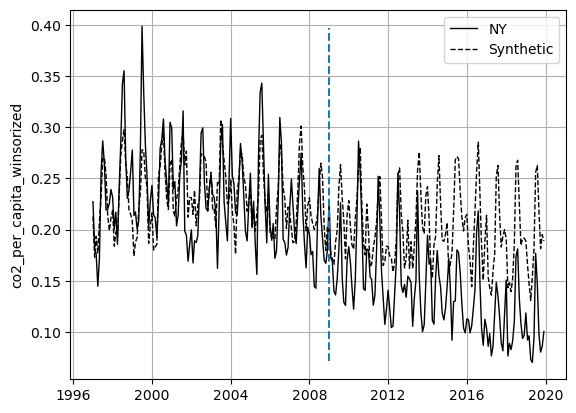

NY Weights: ID    0.671
MN    0.097
FL    0.233
Name: weights, dtype: float64
NY Loss: 0.0011308868837136188



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


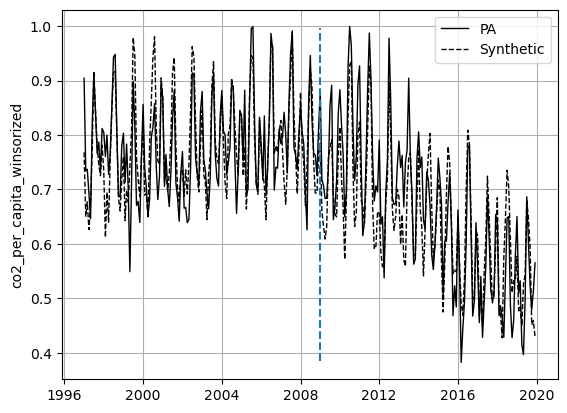

PA Weights: KY    0.029
MT    0.010
TN    0.094
ID    0.024
SD    0.078
IL    0.162
MN    0.178
NM    0.007
SC    0.114
LA    0.172
MS    0.097
WI    0.035
Name: weights, dtype: float64
PA Loss: 0.003356400003376681



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


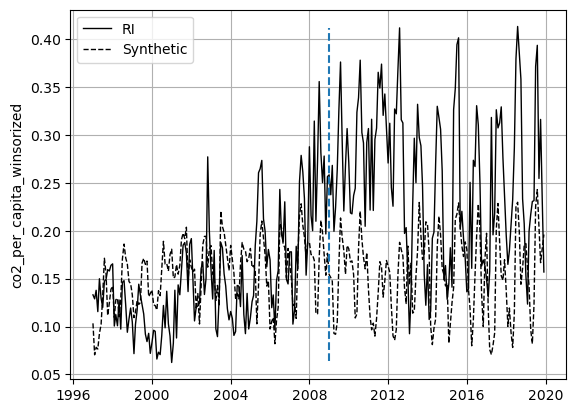

RI Weights: MO    0.005
OR    0.260
ID    0.606
MN    0.010
FL    0.117
WI    0.003
Name: weights, dtype: float64
RI Loss: 0.0028220597969193426



/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


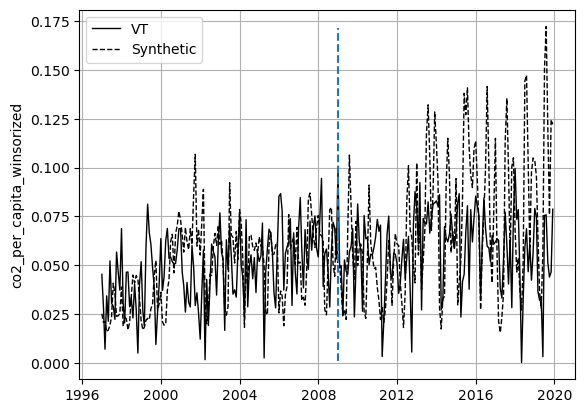

VT Weights: ID    0.968
MN    0.032
Name: weights, dtype: float64
VT Loss: 0.0006001419236913995



In [ ]:
# Compare these to the best fits starting in 1997
for state_id in rggi_states:
    example_predictors = ['co2_per_capita_winsorized', 'prcp', 'tavg', 'eprod_per_capita', 'monthly_fossil_pct']
    #example_predictors = ['co2_per_capita_winsorized', 'tavg', 'eprod_per_capita', 'eflow_per_capita', 'monthly_fossil_pct']
    example_time_range = df.date[(df.date.dt.year>=1997)&(df.date.dt.year<2009)&(df.state==state_id)]
    control_ids = list(set(control_states) - set([state_id]))
    dataprep_example = Dataprep(
                foo=df,
                predictors=example_predictors,
                predictors_op="mean",
                time_predictors_prior=example_time_range,
                #special_predictors=special_predictors,
                dependent="co2_per_capita_winsorized",
                unit_variable="state",
                time_variable="date",
                treatment_identifier=state_id,
                controls_identifier= control_ids,
                time_optimize_ssr=example_time_range
            )
    years = pd.date_range(start='1997-01-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()
    synth = Synth()
    synth.fit(dataprep=dataprep_example)
    synth.path_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
    plt.show()
    print(f"{state_id} Weights:", synth.weights(threshold=.001))
    print(f"{state_id} Loss:", synth.loss_V)
    print("")